### Your name:

<pre> Owen Collins</pre>

### Collaborators:

<pre> None</pre>


### Import modules

In [200]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tarfile
from six.moves import urllib
import pandas as pd
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import impute
from sklearn import compose
from sklearn import pipeline
from sklearn import neighbors
from sklearn import metrics
import seaborn
import scipy
#seaborn.set_style("whitegrid")

### Open the housing data


In [11]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
print("DATA SHAPE:", housing.shape)
housing.head()

DATA SHAPE: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Build full pipeline for the data analysis following the example of the notebook.
 Hint: the main part requested to change is the algorithm used (KNN regression)

#### Considerations for building pipeline:

- Make your notebook as compact as possible. 
- Split data into training and testing sets below.
- Convert all categorical data to one-hot vectors below
- Normalize all non-categorical data 
-  Perform KNN regression using a variety of values for n_neighbors (K) between 1 and 10 and both "uniform" and "distance" weights via a grid search where  *housing_labels* is the output and all other features are the input (similar to as seen in lecture two.)

### Split into training & test set

In [12]:
train_set,test_set = model_selection.train_test_split(housing) #uses default test proportion of 0.25

x_train = train_set.drop("median_house_value", axis=1)
y_train = train_set["median_house_value"].copy()

x_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

### Fix missing values

In [13]:
imputer = impute.SimpleImputer(strategy="mean")

### Normalize data

In [14]:
scaler = preprocessing.StandardScaler()

### Assemble numerical transform pipeline

In [15]:
num_pipeline = pipeline.Pipeline([
    ('imputer', imputer), 
    ('scaler', scaler)])

### Convert categorical data to one-hot, assemble numerical+categorical transform pipeline

In [16]:
num_attribs = list(x_train.select_dtypes(include=[np.number]))
cat_attribs = list(x_train.select_dtypes(include=[object]))
onehot_encoder = preprocessing.OneHotEncoder()

transform_pipeline = compose.ColumnTransformer([
    ("num",num_pipeline,num_attribs),
    ("cat", onehot_encoder,cat_attribs)])

### Add KNN regression to pipeline

In [87]:
knn_regressor = neighbors.KNeighborsRegressor()
full_pipeline = pipeline.Pipeline([
    ('transforms',transform_pipeline),
    ('KNN',knn_regressor)])

### Evaluate KNN regression parameters

In [226]:
knn_weights = ['uniform','distance']
knn_n_neighbors = list(range(1,14))+list(range(14,24,2))+list(range(24,34,4))
param_grid = [{'KNN__weights':knn_weights,'KNN__n_neighbors':knn_n_neighbors}]

grid_search = model_selection.GridSearchCV(full_pipeline,param_grid, n_jobs=4,
                                           cv=12,scoring='neg_mean_squared_error', 
                                           return_train_score=True,verbose=4)
grid_search.fit(x_train,y_train);

Fitting 12 folds for each of 42 candidates, totalling 504 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:   40.7s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 504 out of 504 | elapsed:  2.2min finished


### Plot grid search results

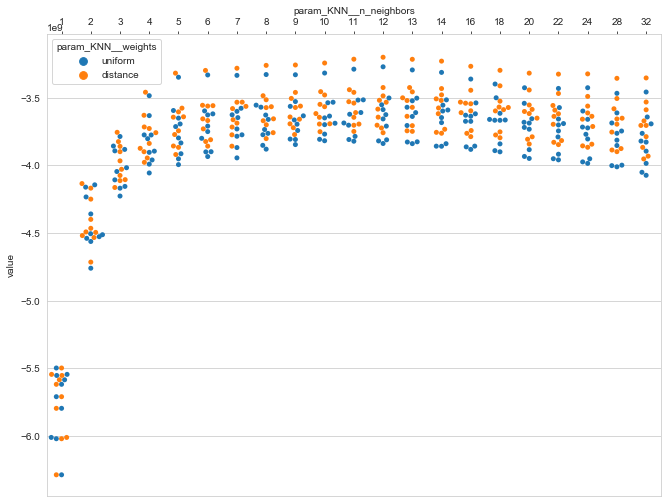

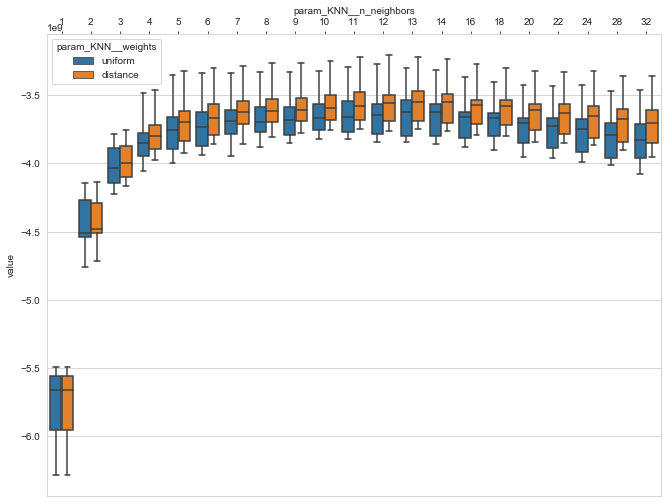

In [227]:
boxscores = pd.DataFrame.from_dict(grid_search.cv_results_)
melted_bs=boxscores.melt(id_vars=['param_KNN__n_neighbors','param_KNN__weights'],value_vars=["split0_test_score","split1_test_score","split2_test_score","split3_test_score","split4_test_score","split5_test_score","split6_test_score","split7_test_score","split8_test_score","split9_test_score"])
fig1, ax1 = plt.subplots()

fig1.set_size_inches(11, 8.5)
seaborn.catplot(x="param_KNN__n_neighbors",y="value",data=melted_bs,hue='param_KNN__weights',kind="swarm",ax=ax1)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top') 
ax

fig2, ax2 = plt.subplots()
fig2.set_size_inches(11, 8.5)
seaborn.boxplot(x="param_KNN__n_neighbors",y="value",data=melted_bs,hue='param_KNN__weights',ax=ax2,whis=2)
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top') 

plt.close(2)
plt.show()

### Determine best model, print information

In [228]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(x_test)
print(str(grid_search.best_params_))
final_mse = metrics.mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print("RMSE: "+str(final_rmse))

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

conf_interval = np.sqrt(scipy.stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=scipy.stats.sem(squared_errors)))
print("95% confidence: "+str(conf_interval))

{'KNN__n_neighbors': 13, 'KNN__weights': 'distance'}
RMSE: 59758.40108825421
95% confidence: [57514.8496755  61920.71598467]


### Conclusions
For what values of n_neighbors and weight does KNeighborsRegressor perform the best? Does it perform as well on the housing data as the linear regressor from the lectures? Why do you think this is?

<pre>KNeighborsRegressor performs best with 13 n_neighbors and "distance" weights. From the lectures, the linear regressor scored an RMSE of 68628. The KNeighborsRegressor scored an RMSE of 59758, which is 13% lower. The KNeighborsRegressor performed better than the linear regressor.

The linear regressor is only able to model linear effects from the data. The KNeighborRegressor may better capture non-linearities in the data. For example: latitude and longitude certainly do not have linear effects on housing prices. Instead, the clusters of latitudes & longitudes which represent cities, rural areas, etc. are likely a good predictor of housing prices & would be captured better by the KNeighborsRegressor.
</pre>

### Read appendix B

- Reflect on your last data project, read appendix B. Then, write down a few of the checklist items that your last data project could have used. If you have not yet done a data project, then write down a few of the items that you found most interesting.

<pre>TBD</pre>

### Submit your notebook

Submit your solution to Quercus
Make sure you rename your notebook to    
W2_UTORid.ipynb    
Example W2_adfasd01.ipynb
